# Section Translation: Mobile Entry Points funnel analysis

# Data-Gathering

## imports

In [42]:
import wmfdata as wmf
import pandas as pd

from datetime import datetime, timedelta

import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
# from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
# import kaleido

from IPython.display import display_html
from IPython.display import display, HTML
from IPython.display import clear_output
import warnings

In [23]:
import great_tables as gt

In [2]:
# init_notebook_mode(connected=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = 250

bold = '\033[1m'
end = '\033[0m'
underline = '\033[4m'

# max width for plotly charts
# iplot_width = 950

# always show options bar
# iplot_config = {'displayModeBar': True}

## functions

In [3]:
# prints a string at center of the output, bold if needed
def pr_centered(content, bold=False):
    if bold:
        content = f"<b>{content}</b>"
    
    centered_html = f"<div style='text-align:center'>{content}</div>"
    
    display(HTML(centered_html))


# display dataframes horizontally with title for each
# inspired from https://medium.com/geekculture/jupyter-how-to-display-dataframes-horizontally-d8e8769f4fa6
def display_h(frames, space=100):
    html = ""
    
    for key in frames.keys():
        html_df =f'<div>{key} {frames[key]._repr_html_()}</div>'
        html += html_df
        
    html = f"""
    <div style="display:flex; justify-content: space-evenly;">
    {html}
    </div>"""
    
    display_html(html, raw=True)

## spark_session

In [7]:
spark_session = wmf.spark.get_active_session()

if type(spark_session) != type(None):
    spark_session.stop()
else:
    print('no active session')

no active session


In [8]:
spark_session = wmf.spark.create_custom_session(
    master="yarn",
    app_name='cx-funnel-entrypoints',
    spark_config={
        "spark.driver.memory": "4g",
        "spark.dynamicAllocation.maxExecutors": 64,
        "spark.executor.memory": "16g",
        "spark.executor.cores": 4,
        "spark.sql.shuffle.partitions": 256,
        "spark.driver.maxResultSize": "2g"
        
    }
)

clear_output()

spark_session

In [10]:
spark_session.sparkContext.setLogLevel("ERROR")

# Data-Gathering

## query

In [11]:
end_dt = '2023-12-31'
start_dt = (datetime.strptime(end_dt, "%Y-%m-%d") - timedelta(days=90)).strftime("%Y-%m-%d")

In [12]:
%%time

query = """
SELECT
    dt AS ts,
    DATE(dt) AS dt,
    HOUR(dt) AS hour,
    wiki_db,
    access_method,
    content_translation_session_id,
    content_translation_session_position,
    event_type,
    event_source,
    translation_type,
    translation_source_language,
    translation_target_language,
    user_is_anonymous,
    user_global_edit_count_bucket,
    year,
    day,
    month
FROM 
    event_sanitized.mediawiki_content_translation_event
WHERE
    DATE(dt) >= DATE('{START_DT}')
    AND DATE(dt) <= DATE('{END_DT}')
"""

all_events = wmf.spark.run(
    query.format(
        START_DT=start_dt, 
        END_DT=end_dt
    )
)

all_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277212 entries, 0 to 277211
Data columns (total 17 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   ts                                    277212 non-null  object
 1   dt                                    277212 non-null  object
 2   hour                                  277212 non-null  int32 
 3   wiki_db                               277212 non-null  object
 4   access_method                         277212 non-null  object
 5   content_translation_session_id        277212 non-null  object
 6   content_translation_session_position  277212 non-null  int64 
 7   event_type                            277212 non-null  object
 8   event_source                          197002 non-null  object
 9   translation_type                      277212 non-null  object
 10  translation_source_language           277185 non-null  object
 11  translation_t

In [92]:
edit_buckets_across_all_sessions = (
    all_events[['content_translation_session_id', 'user_global_edit_count_bucket']]
    .user_global_edit_count_bucket
    .value_counts(normalize=True)
    .reset_index()
    .rename({
        'index': 'edit bucket',
        'user_global_edit_count_bucket': 'percent of events'
    }, axis=1)
    .sort_values('percent of events', ascending=False)
    .set_index('edit bucket')
)

edit_buckets_across_all_sessions['percent of events'] = edit_buckets_across_all_sessions['percent of events'].apply(lambda x:f"{x:.2%}")
print(f'{underline}distribution of edit buckets across all sessions{end}')
edit_buckets_across_all_sessions

distribution of edit buckets across all sessions


,percent of events
edit bucket,
0 edits,53.93%
1000+ edits,19.20%
5-99 edits,10.76%
100-999 edits,9.87%
1-4 edits,6.24%


### Data-Cleaning
During analysis, several issues related to events produced were identified. The most significant issue was with `content_translation_session_position` where multiple events belongs to different and same event types although occured at different times, have the same session position. Currently, we are not sure whether the session position was being recorded incorrectly, in which it can be re-constructed based on the timestamp, or if they are duplicate events. More information and task to investigate these issues is at [T353882](https://phabricator.wikimedia.org/T353882). For this analysis, all sessions with potentially erroneous events will not be considered.

In [14]:
temporal_columns = ['ts', 'dt', 'hour']

# sessions with duplicate events expect for the temporal columns
sessions_with_duplicate_events = (
    all_events[[col for col in all_events.columns.tolist() if col not in temporal_columns]]
    .value_counts()
    .reset_index()
    .rename({0: 'count'}, axis=1)
    .query("""count > 1""")
    .content_translation_session_id
    .unique()
    .tolist()
)

# various event types in a session having same session position althoguh the events occured later
session_event_counts = (
    all_events.groupby(['content_translation_session_id', 'content_translation_session_position'])
    .agg(distinct_events=('event_type', pd.Series.nunique))
)

sessions_with_same_position_events = (
    session_event_counts.query("""distinct_events > 1""")
    .reset_index()
    .content_translation_session_id
    .unique()
    .tolist()
)

# sessions where multiple global edit count buckets were recorded
sessions_with_multiple_edit_counts = (
    all_events.groupby('content_translation_session_id')['user_global_edit_count_bucket']
    .nunique()
    .reset_index()
    .query("""user_global_edit_count_bucket > 1""")
    .content_translation_session_id
    .unique()
    .tolist()
)

# sessions with no dashboard open at start
sessions_with_no_dopen_start = (
    all_events.query("""(content_translation_session_position == 0) & (event_type != 'dashboard_open')""")
    .content_translation_session_id
    .unique()
    .tolist()
)

sessions_with_dopen = (
    all_events
    .query("""event_type == 'dashboard_open'""")['content_translation_session_id']
    .unique()
    .tolist()
)

# sessions without dashboard open
sessions_without_dopen = (
    all_events
    .query("""content_translation_session_id != @sessions_with_dopen""")['content_translation_session_id']
    .unique()
    .tolist()
)

# sessions with multiple events having same session position
duplicate_events_with_same_position = (
    all_events[['content_translation_session_id', 'content_translation_session_position', 'event_type']]
    .value_counts()
    .reset_index()
    .rename({0: 'count'}, axis=1)
    .query("""count > 1""")
    .content_translation_session_id
    .unique()
    .tolist()
)

In [15]:
# remove all potentially invalid sessions
invalid_sessions = list(
    set(
        [*sessions_with_duplicate_events,
         *sessions_with_same_position_events,
         *sessions_with_multiple_edit_counts, 
         *sessions_with_no_dopen_start, 
         *sessions_without_dopen, 
         *duplicate_events_with_same_position]
    )
)

events = all_events.query("""content_translation_session_id != @invalid_sessions""")

In [16]:
# ensure session positions follows timestamp; fix if needed
def is_session_position_consistent(group):
    return group['content_translation_session_position'].is_monotonic_increasing

events = events.sort_values(by=['content_translation_session_id', 'ts'])
consistency_check = events.groupby('content_translation_session_id').apply(is_session_position_consistent)

assert len(consistency_check[consistency_check == False].index.tolist()) == 0, \
    f'{len(consistency_check[consistency_check == False])} sessions have inconsistent position'

In [18]:
n_all_sessions = all_events.content_translation_session_id.nunique()
n_all_events = all_events.shape[0]

n_valid_sessions = events.content_translation_session_id.nunique()
n_events_from_valid_sessions = events.shape[0]

pct_invalid_sessions = 100 - round(n_valid_sessions / n_all_sessions * 100, 2) 

print(f'\t- all sessions: {n_all_sessions}; all events: {n_all_events}\n\
        - valid sessions: {n_valid_sessions}; events from valid sessions: {n_events_from_valid_sessions}\n\
        - percentage of sessions with potentially erroneous events {pct_invalid_sessions}%')

	- all sessions: 29365; all events: 277212
        - valid sessions: 15143; events from valid sessions: 87874
        - percentage of sessions with potentially erroneous events 48.43%


In [19]:
# change to appropriate datatypes

edit_buckets = ['0 edits', '1-4 edits', '5-99 edits', '100-999 edits', '1000+ edits']

events = (
    events
    .assign(
        user_global_edit_count_bucket=pd.Categorical(events['user_global_edit_count_bucket'], categories=edit_buckets, ordered=True),
        ts=pd.to_datetime(events['ts'], utc=True)
    )
    .sort_values(by=['content_translation_session_id', 'content_translation_session_position'])
    .reset_index(drop=True)
)

events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87874 entries, 0 to 87873
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype              
---  ------                                --------------  -----              
 0   ts                                    87874 non-null  datetime64[ns, UTC]
 1   dt                                    87874 non-null  object             
 2   hour                                  87874 non-null  int32              
 3   wiki_db                               87874 non-null  object             
 4   access_method                         87874 non-null  object             
 5   content_translation_session_id        87874 non-null  object             
 6   content_translation_session_position  87874 non-null  int64              
 7   event_type                            87874 non-null  object             
 8   event_source                          62045 non-null  object             
 9   translation_type 

# Analysis

## Entry points: Dashboard Open
As the goal is to understand how users reach the translation dashboard, this part of the analysis only includes events where users navigate to main dashboard from an external source. For example, after adding a segement, a user can come back to dashboard for another translation, and these events are currently being recorded as `direct` acess ([T353799](https://phabricator.wikimedia.org/T353799)), such `dashboard_open` events are not considered for this part.

### Overall

In [20]:
dopen_events = (
    events
    .query("""(event_type == 'dashboard_open') & (content_translation_session_position == 0)""")
    .reset_index(drop=True)
)

In [109]:
dopen_edit_counts = (
    dopen_events[['content_translation_session_id', 'user_global_edit_count_bucket']]
    .user_global_edit_count_bucket
    .value_counts(normalize=True)
    .reset_index()
    .rename({
        'user_global_edit_count_bucket': 'Percentage',
        'index': 'Edit Bucket'
    }, axis=1)
    .sort_values('Edit Bucket')
)

dopen_edit_counts_table = (
    gt
    .GT(dopen_edit_counts)
    .fmt_percent(columns='Percentage')
    .tab_header(title='Frequency of Users\' Edit Buckets', subtitle='that initiated dashboard open events')
    .tab_source_note(f'across {dopen_events.content_translation_session_id.nunique()} sessions from {start_dt} to {end_dt}')
)


GT(_tbl_data=     Edit Bucket  Percentage
0        0 edits    0.492503
4      1-4 edits    0.083494
2     5-99 edits    0.153728
3  100-999 edits    0.095689
1    1000+ edits    0.174585, _body=<great_tables._gt_data.Body object at 0x7fc37c142ad0>, _boxhead=Boxhead([ColInfo(var='Edit Bucket', type=<ColInfoTypeEnum.default: 1>, column_label='Edit Bucket', column_align='center', column_width=None), ColInfo(var='Percentage', type=<ColInfoTypeEnum.default: 1>, column_label='Percentage', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([]), _heading=Heading(title="Frequency of Users' Edit Buckets", subtitle='that initiated dashboard open events', preheader=None), _stubhead=None, _source_notes=['across 15007 sessions from 2023-10-02 to 2023-12-31'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7fc377e226e0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7fc377e214e0>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=None), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px'

In [40]:
entry_points_freq = (
    dopen_events.event_source
    .value_counts(normalize=True)
    .reset_index()
    .rename({
        'index': 'entry_point',
        'event_source': 'percent'        
    }, axis=1)
)

In [112]:
entry_points_table = (
    gt
    .GT(entry_points_freq)
    .fmt_percent(columns='percent')
    .cols_label(
        entry_point='Entry Point',
        percent='Percentage'
    )
    .tab_header('Overall Distribution Of Entry Points That Users Navigate From', 'To Reach the Content Translation dashboard')
    .tab_source_note(f'across {dopen_events.content_translation_session_id.nunique()} sessions from {start_dt} to {end_dt}')
)

entry_points_table

GT(_tbl_data=                   entry_point   percent
0           frequent_languages  0.726861
1    content_language_selector  0.159392
2                       direct  0.063704
3  invite_new_article_creation  0.032185
4             direct_preselect  0.013327
5           contributions_page  0.002466
6           recent_translation  0.002066, _body=<great_tables._gt_data.Body object at 0x7fc377e548b0>, _boxhead=Boxhead([ColInfo(var='entry_point', type=<ColInfoTypeEnum.default: 1>, column_label='Entry Point', column_align='left', column_width=None), ColInfo(var='percent', type=<ColInfoTypeEnum.default: 1>, column_label='Percentage', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([]), _heading=Heading(title='Overall Distribution Of Entry Points That Users Navigate From', subtitle='To Reach the Content Translation dashboard', preheader=None), _stubhead=None, _source_notes=['across 15007 sessions from 2023-10-02 to 2023-12-31'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7fc377e22500>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7fc377e221d0>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=None), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_

### By Edit Bucket

In [113]:
entry_by_edit_bucket = (
    dopen_events
    .groupby(['user_global_edit_count_bucket', 'event_source'])
    .size()
    .reset_index()
    .rename({
        'user_global_edit_count_bucket': 'edit_bucket',
        'event_source': 'source',
        0: 'count'
    }, axis=1)
    .sort_values(['edit_bucket', 'count'], ascending=[True, False])
    .reset_index(drop=True)
)

entry_by_edit_bucket['total'] = (
    entry_by_edit_bucket['edit_bucket']
    .map(entry_by_edit_bucket
         .groupby('edit_bucket')
         .agg({'count': sum})
         .to_dict()['count']
    )
)

entry_by_edit_bucket = entry_by_edit_bucket.astype({'total': int})
entry_by_edit_bucket['percent'] = entry_by_edit_bucket['count'] / entry_by_edit_bucket['total']

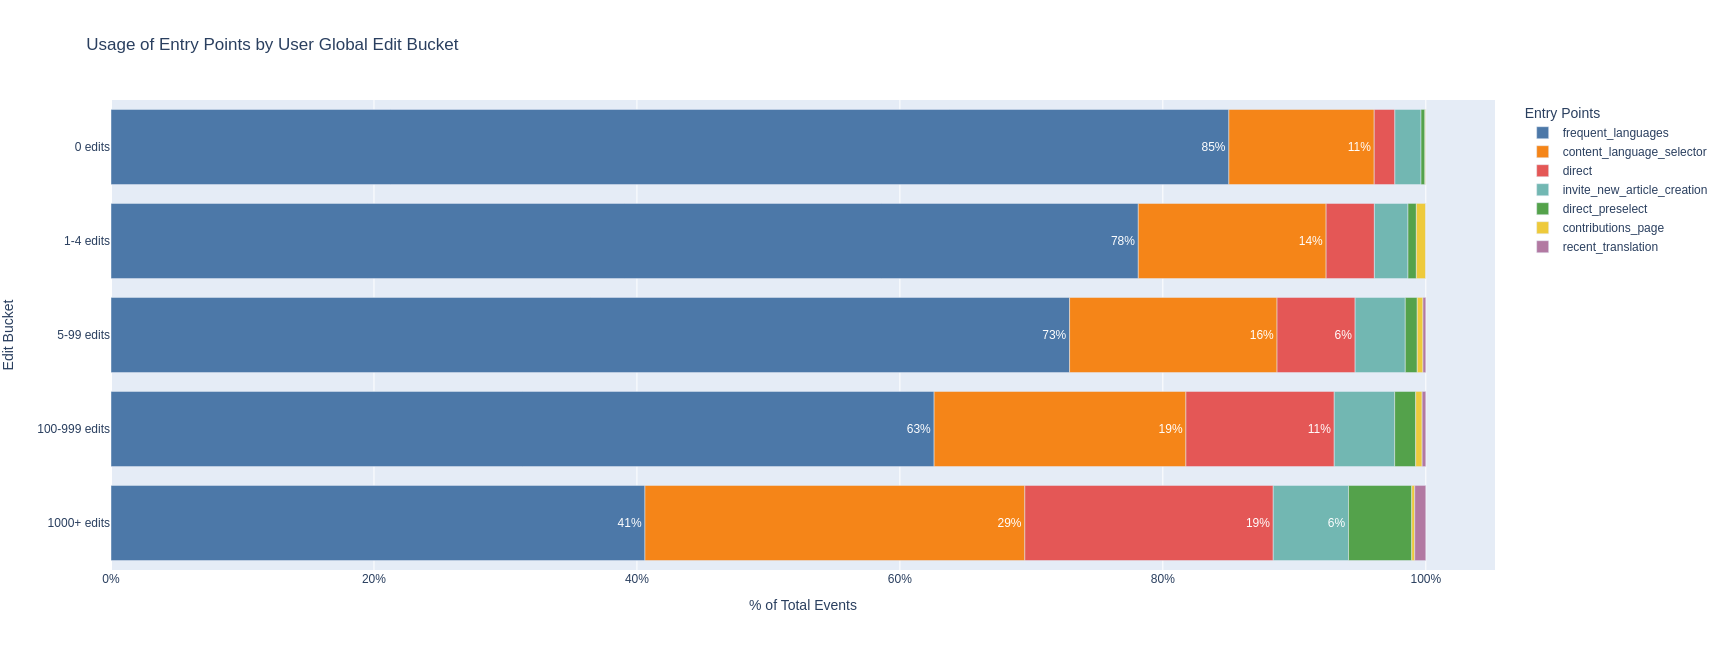

In [114]:
entry_by_edit_bucket['percent_annot'] = (
    entry_by_edit_bucket['percent']
    .apply(lambda x:f"{x:.0%}" if x > 0.05 else None)
)

fig = px.bar(entry_by_edit_bucket, 
             x='percent', 
             y='edit_bucket', 
             color='source',
             labels={
                 'percent':'% of Total Events', 
                 'edit_bucket': 'Edit Bucket', 
                 'source': 'Entry Points'
             },
             color_discrete_sequence=px.colors.qualitative.T10,
             title='Usage of Entry Points by User Global Edit Bucket',
             text='percent_annot', 
             category_orders={
                 'edit_bucket': edit_buckets, 
                 'source': entry_points_freq.entry_point.values.tolist()
             }
            )


fig.update_layout(barmode='relative', height=650)
fig.update_xaxes(tickformat='.0%')
fig.update_traces(
    textfont_color='white', 
    hovertemplate="<br>".join([
        "Edit Bucket: %{y}",
        "Percent of Total Events: %{x:.0%}"
    ])
)

fig.show()

**Summary**
- 85% of the newcomers open the translation dashboard by navigating from frequent languages selector, which surfaces missing languages to translate for an article.
- As users gain more editing experience, more users tend to reach the dashboard increasinly through content language selector, which they can search for missing language to translate for an article.
- Also, experienced users tend to open the dashboard directly as compared to newcomers.
- For users with 1000+ edits, frequent languages selector is only 40% of the time to navigate to dashboard.

### By Wiki size: Translation Target Language
comparative sizes are based on https://github.com/wikimedia-research/wiki-comparison

In [53]:
wiki_comp = pd.read_csv('https://raw.githubusercontent.com/wikimedia-research/wiki-comparison/main/data-collection/snapshots/Jan_2023.tsv', sep='\t')
wp_comp = (
    wiki_comp[wiki_comp['project code'] == 'wikipedia']
    .reset_index(drop=True)
    .reset_index()[['index', 'database code', 'language code', 'language name', 'monthly active editors']]
    .rename({
        'index': 'rank', 
        'database code': 'db_code', 
        'language code': 'lang_code', 
        'language name': 'lang_name',
        'monthly active editors': 'active_editors'
    }, axis=1)
)

wp_comp['rank'] = wp_comp['rank'] + 1

In [54]:
rank_bin_edges = [0, 5, 10, 20, 50, float('inf')]
rank_bin_labels = ['1-5', '6-10', '11-20', '21-50', '51-max']

wp_comp['rank_bin'] = pd.cut(
    wp_comp['rank'], 
    bins=rank_bin_edges, 
    labels=rank_bin_labels
)

In [55]:
dopen_events = (
    dopen_events
    .merge(
        wp_comp[['lang_code', 'rank_bin']],
        how='left',
        left_on='translation_target_language',
        right_on='lang_code'
    )
    .rename(columns={'rank_bin': 'target_wp_rank'})
    .drop('lang_code', axis=1)
)

In [128]:
entry_by_target_wp_size = (
    dopen_events
    .groupby(['target_wp_rank', 'event_source'])
    .size()
    .reset_index()
    .rename({
        'event_source': 'source',
        0: 'count'
    }, axis=1)
    .sort_values(['target_wp_rank', 'count'], ascending=[True, False])
    .reset_index(drop=True)
)

In [129]:
entry_by_target_wp_size['total'] = (
    entry_by_target_wp_size['target_wp_rank']
    .map(entry_by_target_wp_size
         .groupby('target_wp_rank')
         .agg({'count': sum})
         .to_dict()['count']
    )
)

entry_by_target_wp_size = entry_by_target_wp_size.astype({'total': int})
entry_by_target_wp_size['percent'] = entry_by_target_wp_size['count'] / entry_by_target_wp_size['total']

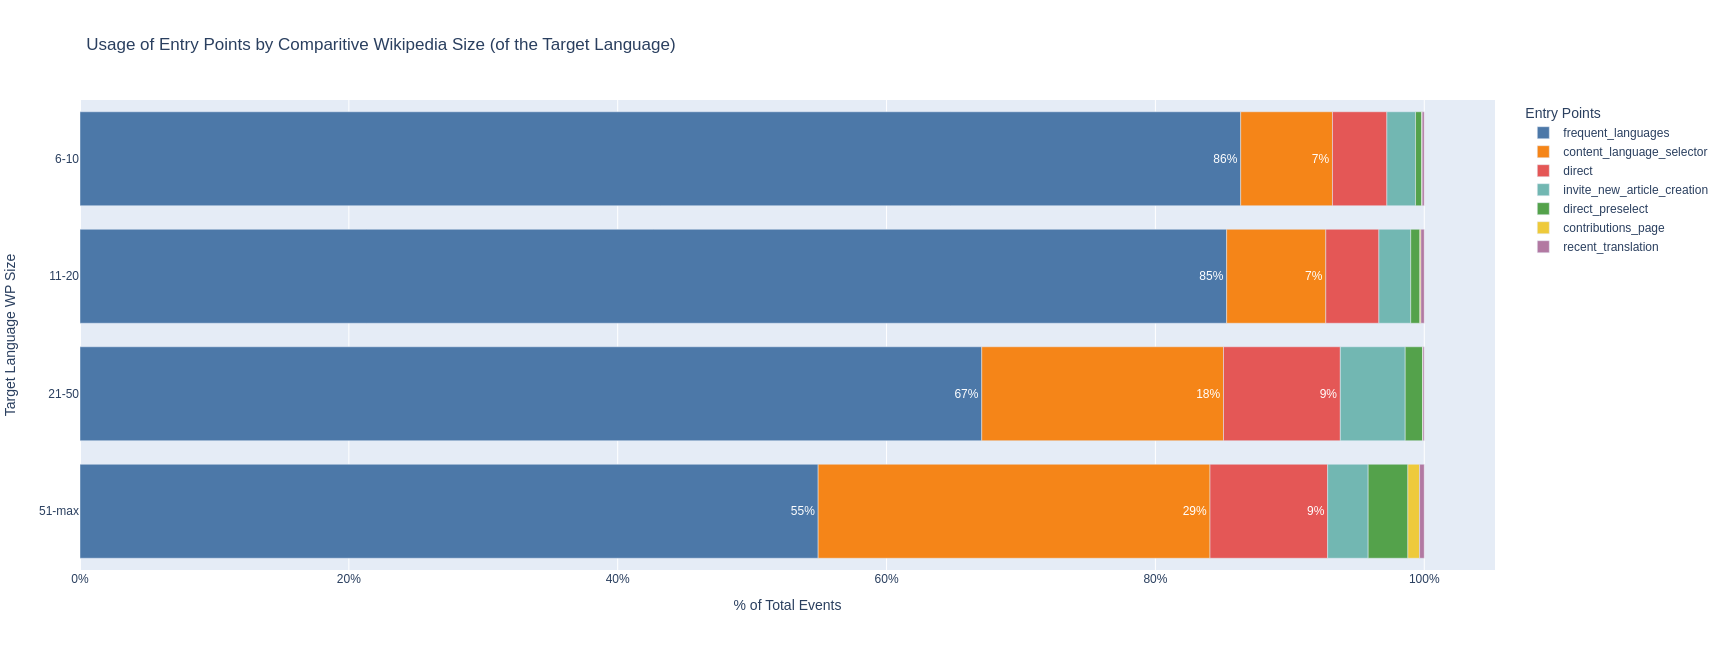

In [135]:
entry_by_target_wp_size['percent_annot'] = (
    entry_by_target_wp_size['percent']
    .apply(lambda x:f"{x:.0%}" if x > 0.05 else None)
)

fig = px.bar(entry_by_target_wp_size.query("""target_wp_rank != '1-5'"""), 
             x='percent', 
             y='target_wp_rank', 
             color='source',
             labels={
                 'percent':'% of Total Events', 
                 'target_wp_rank': 'Target Language WP Size', 
                 'source': 'Entry Points'
             },
             color_discrete_sequence=px.colors.qualitative.T10,
             title='Usage of Entry Points by Comparitive Wikipedia Size (of the Target Language)',
             text='percent_annot', 
             category_orders={
                 'target_wp_rank': [i for i in rank_bin_labels if i != '1-5'], 
                 'source': entry_points_freq.entry_point.values.tolist()
             }
            )


fig.update_layout(barmode='relative', height=650)
fig.update_xaxes(tickformat='.0%')
fig.update_traces(textfont_color='white')

fig.show()

**Summary**
- On larger Wikipedias, frequent languages selector is most used to navigate to the translation dashboard. 
    - Among the top 20 Wikipedias, it was used 85% of the time to access the dashboard.
- On smaller Wikipedias, although frequent languages selector still remains the most accessed, usage of content language selctor is increasinly more.
- This trend is related to the observations from user edit bucket, larger Wikipedias tend to have more newcomers compared to smaller Wikipedias.

## Sources: Dashboard Translation Start
The next step after opening the translation dashboard, is the dashboard translation start page, which appears after a user confirms their choice of article/section to translate. This step occurs before the translation editing screen. In this section, various sources through which users reach the translation start page have been analyzed. This step can take place in two scenarios:
1. When users from an external source navigate to the dashboard (i.e. entry points such as frequent languages and content languages selctors), the opening of translation dashboard is immediately followed by translation start screen. In such cases, the `event_source` for `dashboard_translation_start` will be same as the source for `dashboard_open`. For example, if a user clicks on a link from frequent languages selector, `dashboard_open` and `dashboard_translation_start` events are consecutively triggered, with both having event source as `frequent_languages`. This is because selection of article/section has already happened.
2. When users reach the main dashboard either by directly opening, or return after editing/completing a translation, there are multiple ways users are shown suggestions, and upon selection, sources specific to `dashboard_translation_start` get logged.

For this section, only events generated from the second scenario are considered, as the first scenario is caused due to the sources of `dashboard_open`.

In [241]:
dopen_sources = events.query("""event_type == 'dashboard_open'""").event_source.unique().tolist()
dtstart_self_events = events.query("""(event_type == 'dashboard_translation_start') & (event_source != @dopen_sources)""")
dstart_sources_freq = dtstart_self_events.event_source.value_counts()
pct_dopen_independent_events = round(dtstart_self_events.shape[0] / events.query("""(event_type == 'dashboard_translation_start')""").shape[0] * 100, 2)

In [224]:
dstart_sources_freq_by_bucket = (
    dtstart_self_events[['event_source', 'user_global_edit_count_bucket']]
    .value_counts()
    .reset_index()
    .rename({
        0: 'n_events',
        'event_source': 'Source',
        'user_global_edit_count_bucket': 'Edit Bucket'
    }, axis=1)
    .sort_values(['Source', 'Edit Bucket'])
)

dstart_sources_freq_by_bucket['source_total_events'] = dstart_sources_freq_by_bucket['Source'].map(dstart_sources_freq.to_dict())
dstart_sources_freq_by_bucket['Percentage'] = (dstart_sources_freq_by_bucket['n_events'] / dstart_sources_freq_by_bucket['source_total_events']).apply(lambda x:f"{x:.2%}")

In [240]:
pr_centered('Frequency of Sources for Dashboard Translation Start events, by Edit Count Bucket', True)
pr_centered(f'percentage of dashboard_translation_start events that occurred independent of dashboard_open events is: {pct_dopen_independent_events}%', True)
display_h({
    f'{source} ({dstart_sources_freq.to_dict()[source]} events)':(
        dstart_sources_freq_by_bucket
        .query("""Source == @source""")[['Edit Bucket', 'Percentage']]
        .set_index('Edit Bucket')
    ) for source in dstart_sources_freq.index
})

,Percentage
Edit Bucket,
0 edits,55.61%
1-4 edits,8.42%
5-99 edits,16.63%
100-999 edits,8.84%
1000+ edits,10.50%
,Percentage
Edit Bucket,
0 edits,8.13%
1-4 edits,4.88%


**Summary**
- Only 7% of the `dashboard_translation_start` have occurred independently of `dashboard_open` events.
    - That indicates that most of the users start the translations by already selecting article/section to translate on from an external entry point.
- Among the ones who initiate `dashboard_translation_start` independently
    - Majority of the newcomers start a translation by accepting suggestion by the API in the absence of a seed article.
    - Majority of the expericed users start a translation by choosing results of a search, followed by accepting a translation suggested because it is related to one of their recent edits.


## Funnel

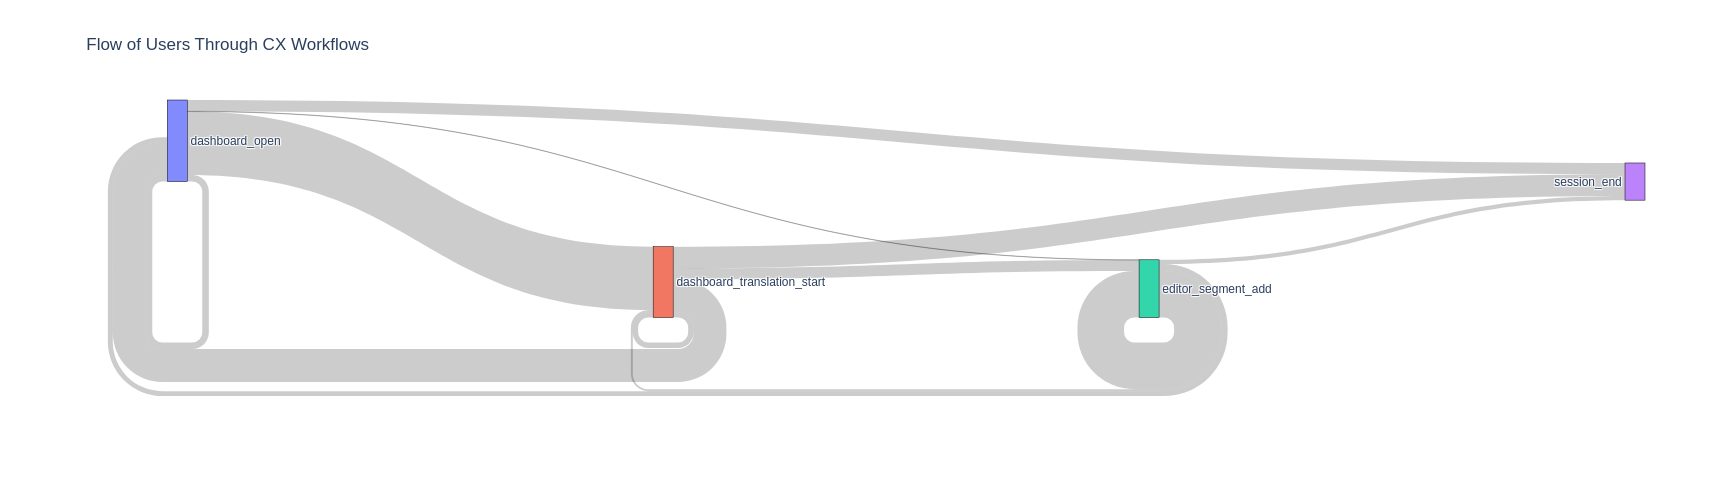

In [304]:
main_events = ['dashboard_open', 'dashboard_translation_start', 'editor_segment_add']

def plot_sankey(df, 
                return_transition_data=False,
                chart_title=None,
                events_scope=main_events, 
                incl_session_end=True, 
                font_size=12, height=450, width=900):
    
    warnings.filterwarnings('ignore')
        
    df = df.query("""event_type == @events_scope""")    
    df = df.sort_values(by=['content_translation_session_id', 'content_translation_session_position'])

    df['next_event_type'] = df.groupby('content_translation_session_id')['event_type'].shift(-1)

    if incl_session_end:
        df['next_event_type'].fillna('session_end', inplace=True)
    else:
        df.dropna(subset=['next_event_type'], inplace=True)

    transition_counts = df.groupby(['event_type', 'next_event_type']).size().reset_index(name='count')
    total_transitions_by_source = transition_counts.groupby('event_type')['count'].sum()
    transition_counts['total_by_source'] = transition_counts['event_type'].map(total_transitions_by_source)
    transition_counts['percentage'] = (transition_counts['count'] / transition_counts['total_by_source']) * 100
    
    if return_transition_data:
        return transition_counts
    else:
        all_event_types = pd.concat([transition_counts['event_type'], transition_counts['next_event_type']]).unique()
        label_mapping = {label: idx for idx, label in enumerate(all_event_types)}

        sources = transition_counts['event_type'].map(label_mapping)
        targets = transition_counts['next_event_type'].map(label_mapping)
        weights = transition_counts['count']

        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=all_event_types
            ),
            link=dict(
                source=sources,
                target=targets,
                value=weights,
                hovertemplate='Events: %{value}<br />' +
                              'Percentage: %{customdata:.2f}%<extra></extra>',
                customdata=transition_counts['percentage']
            ))])

        fig.update_layout(title_text=chart_title, font_size=12, height=500, width=850)
        fig.show()
    
plot_sankey(events, chart_title='Flow of Users Through CX Workflows')

In [ ]:
print(plot_sankey(events, return_transition_data=True))

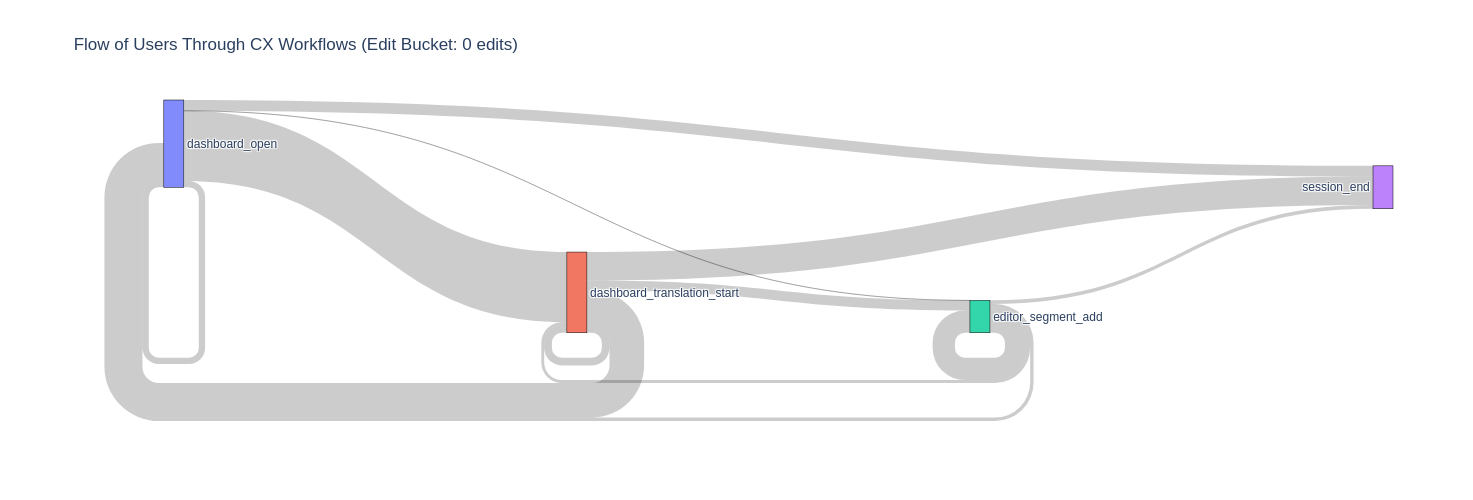

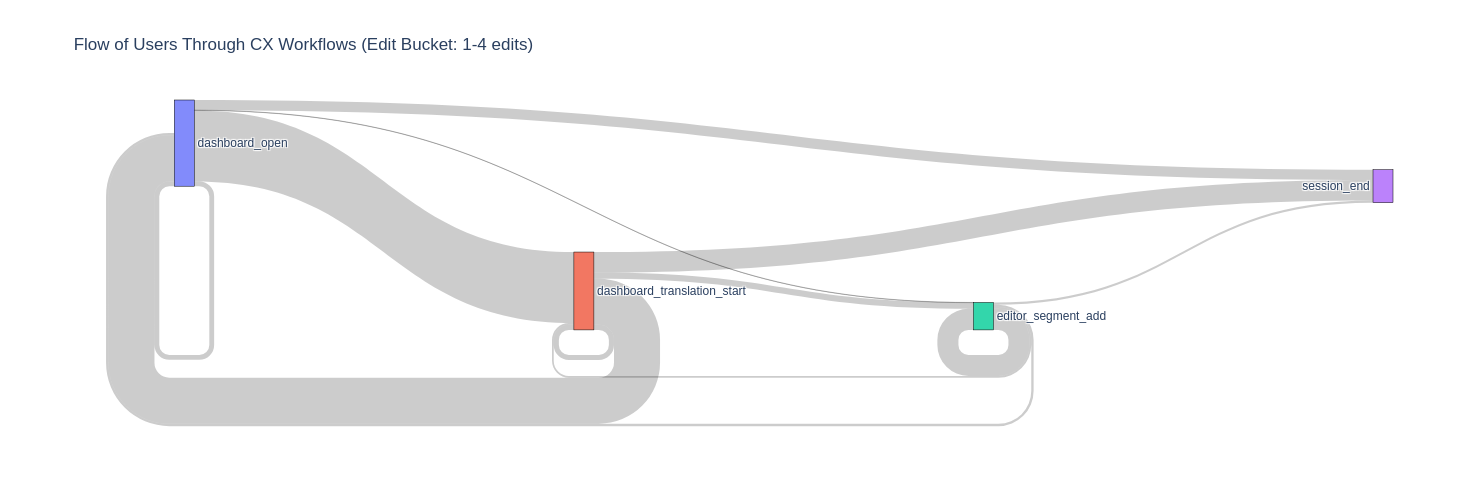

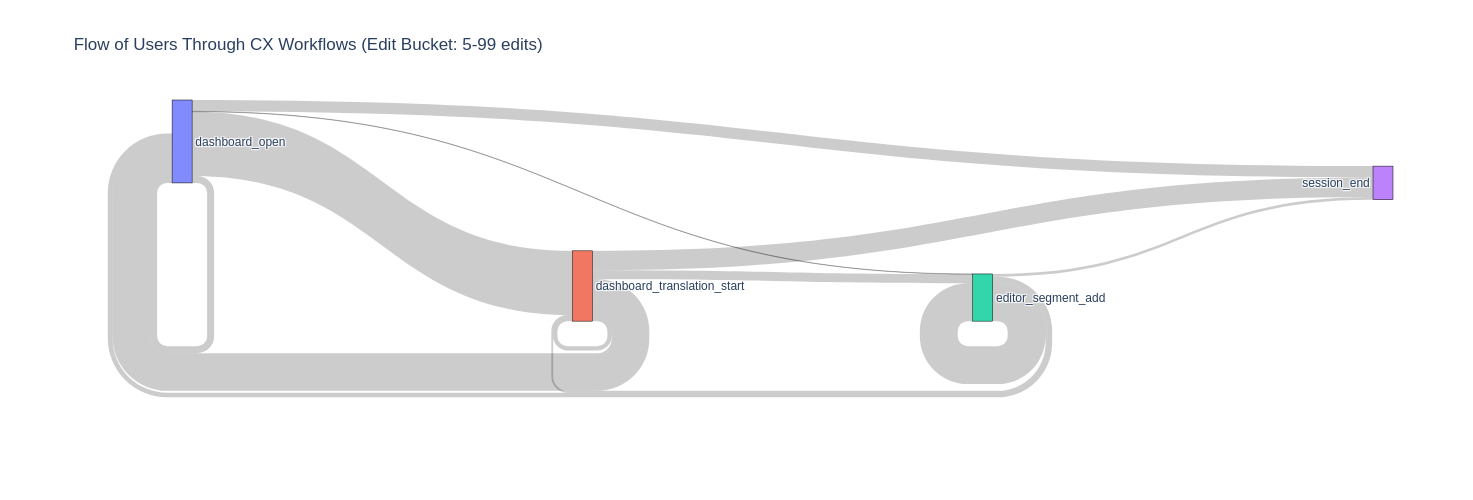

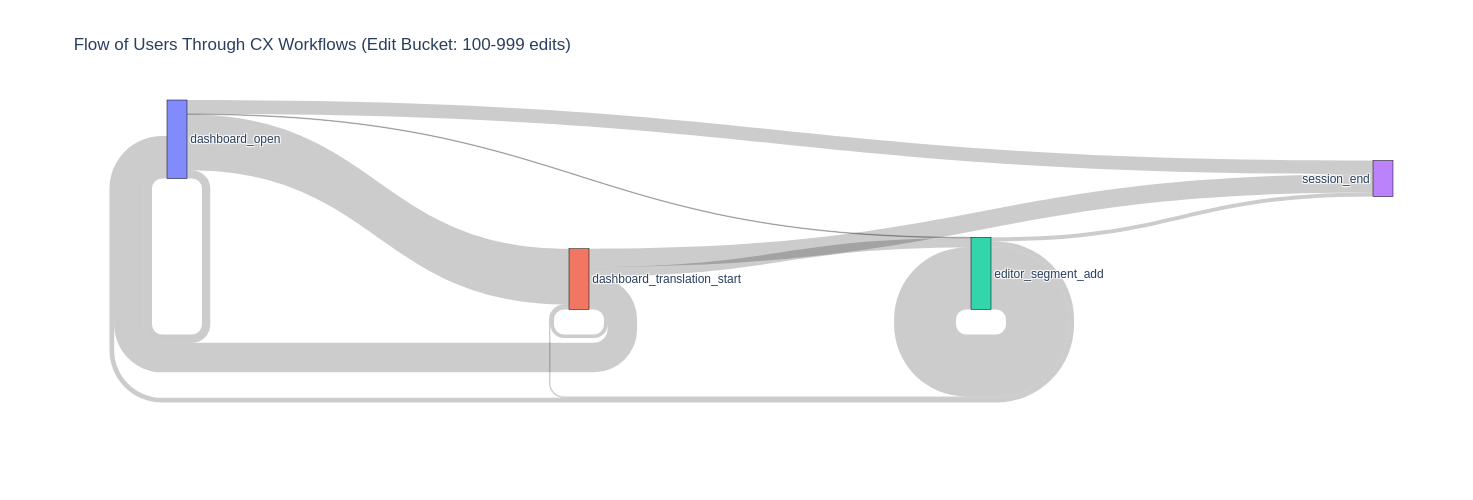

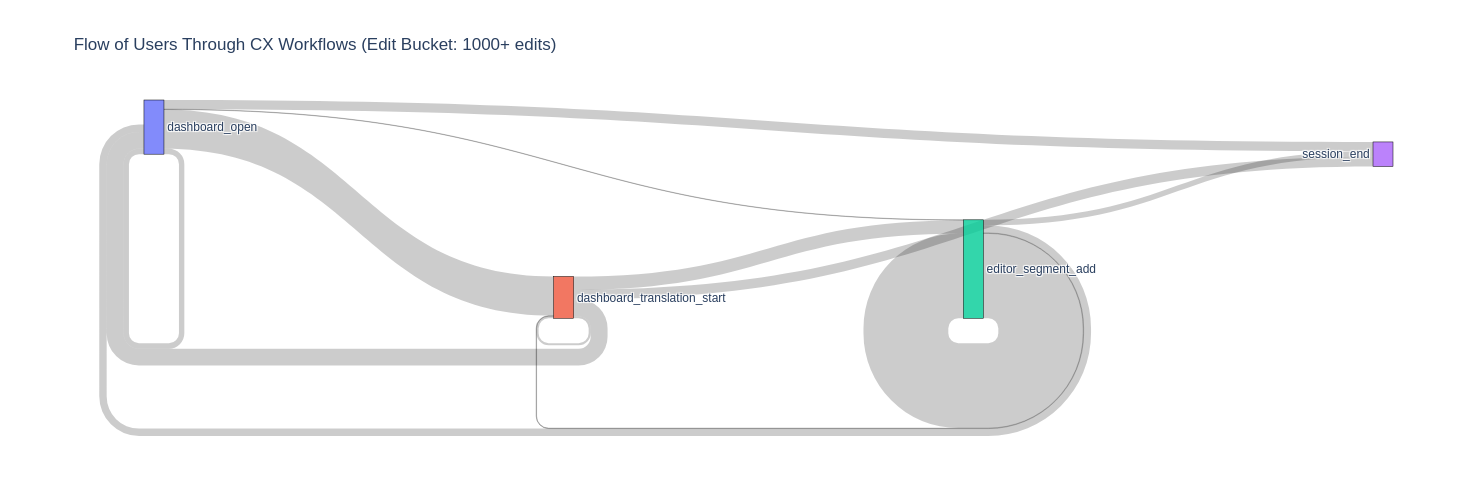

In [271]:
for bucket in edit_buckets:
    plot_sankey(events.query(f"""user_global_edit_count_bucket == '{bucket}'"""), f'Flow of Users Through CX Workflows (Edit Bucket: {bucket})')

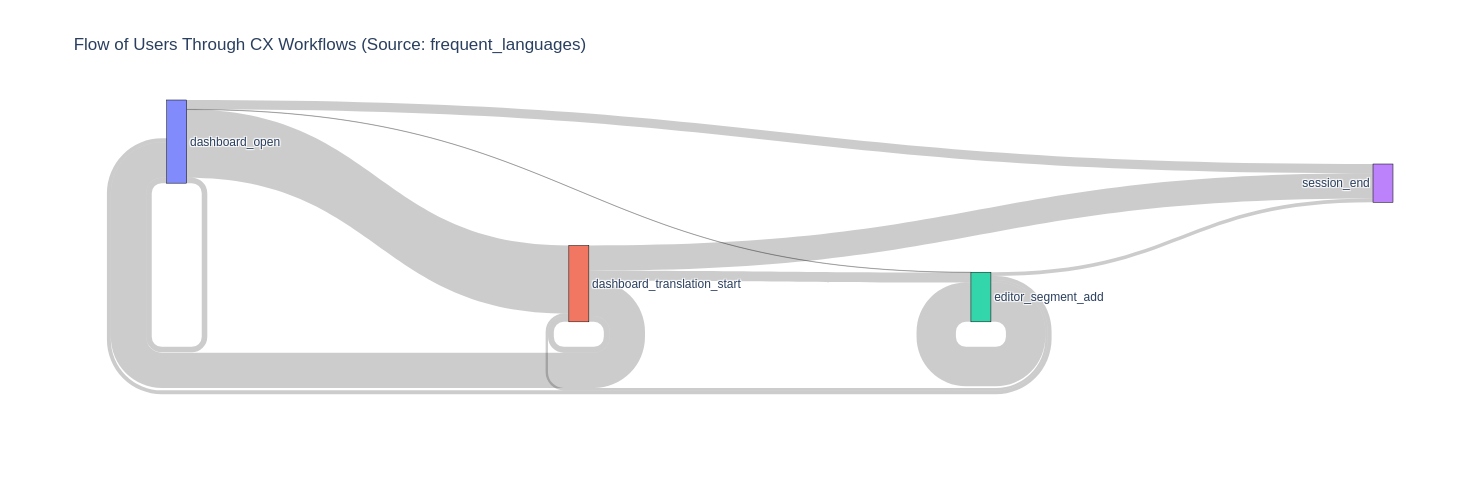

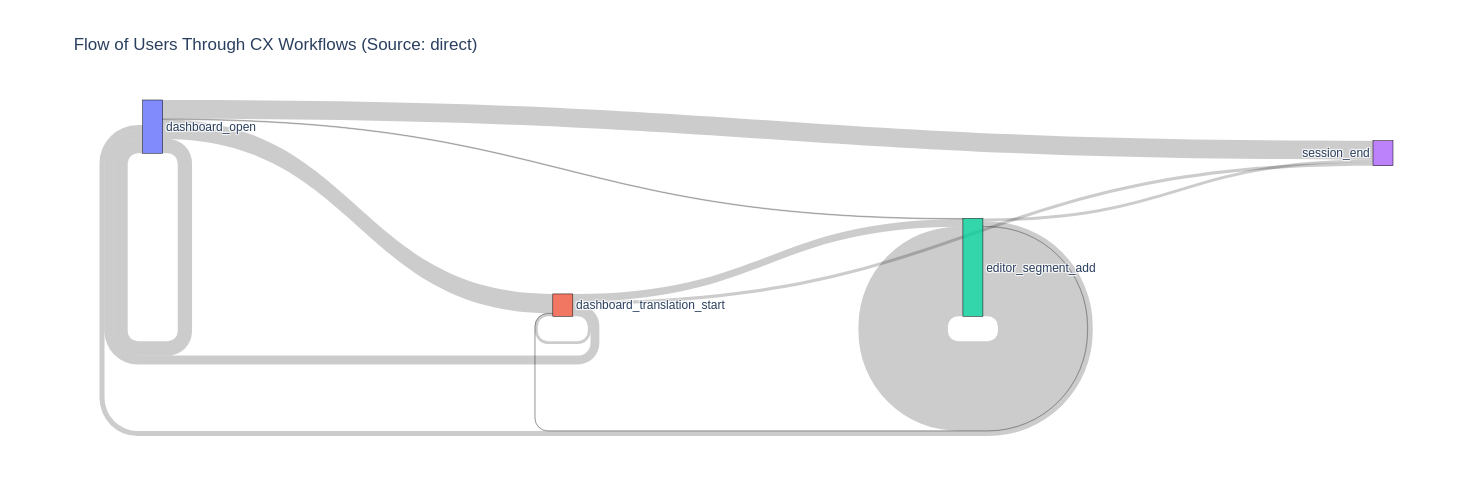

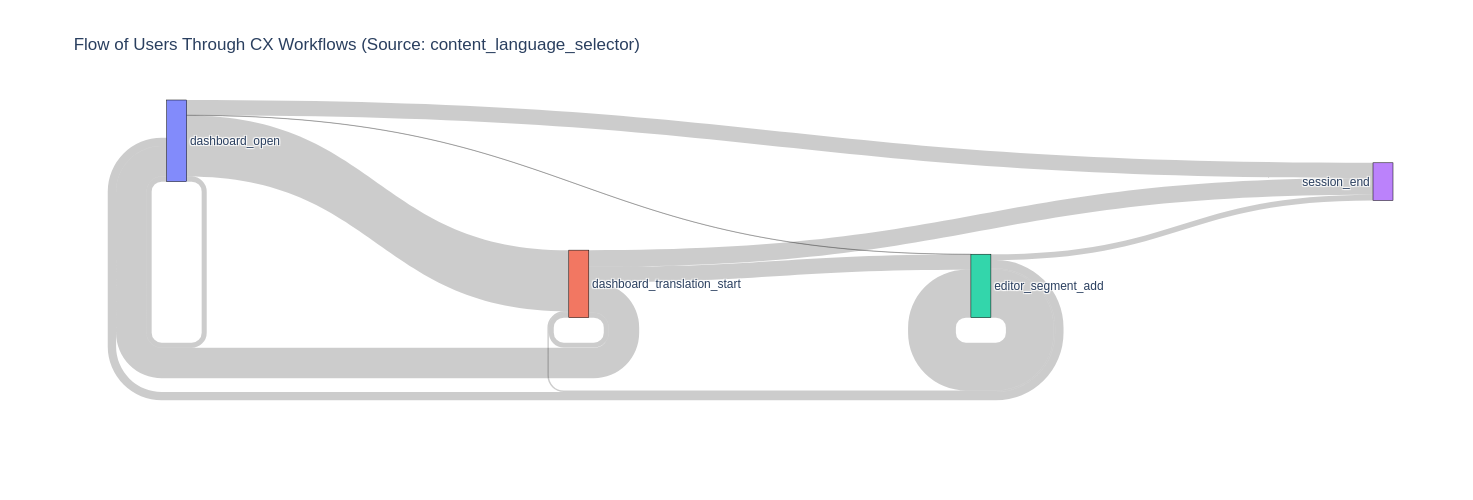

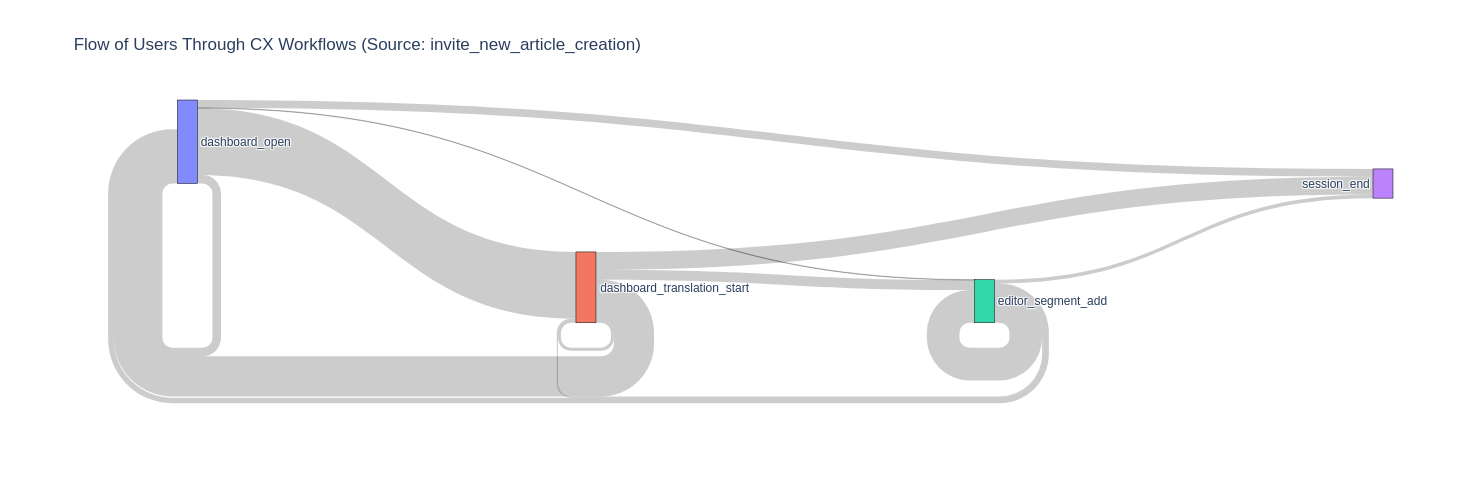

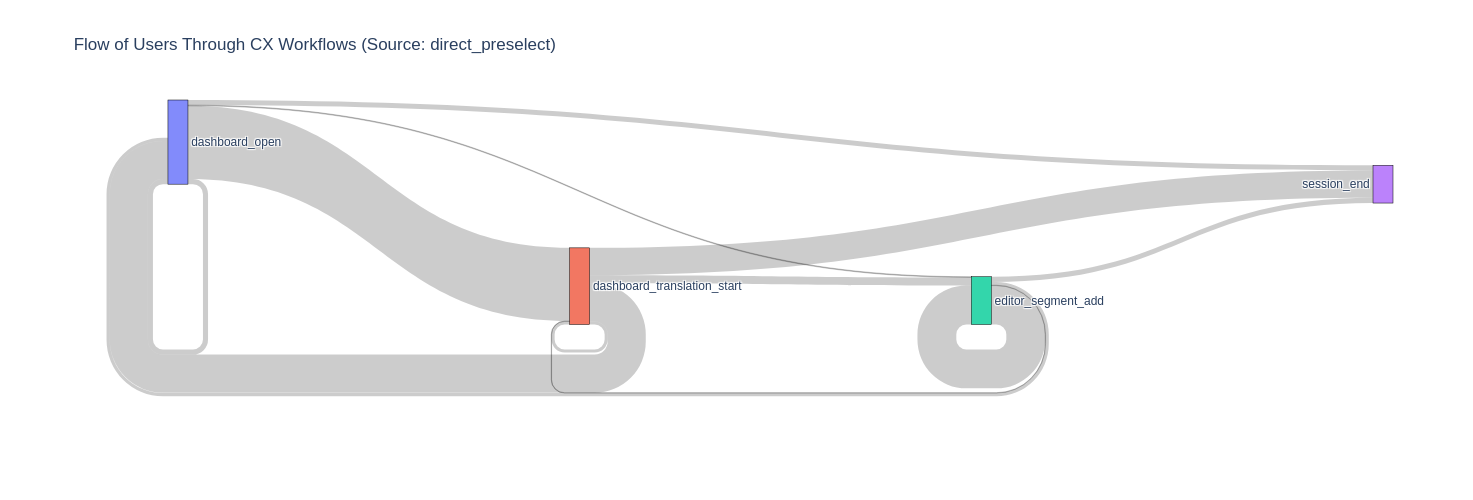

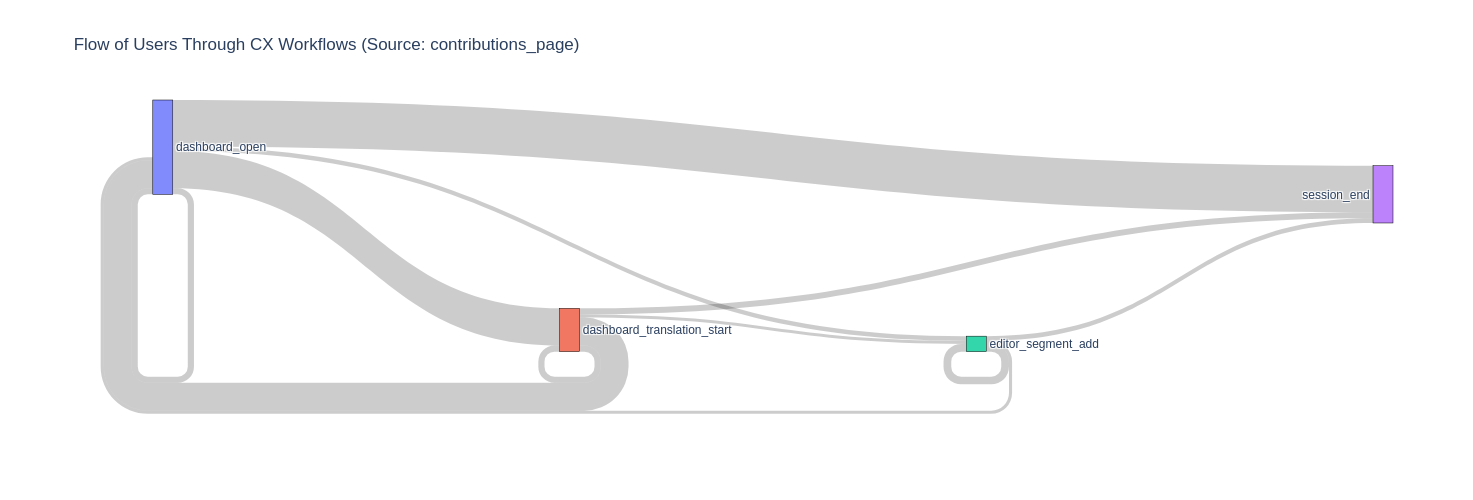

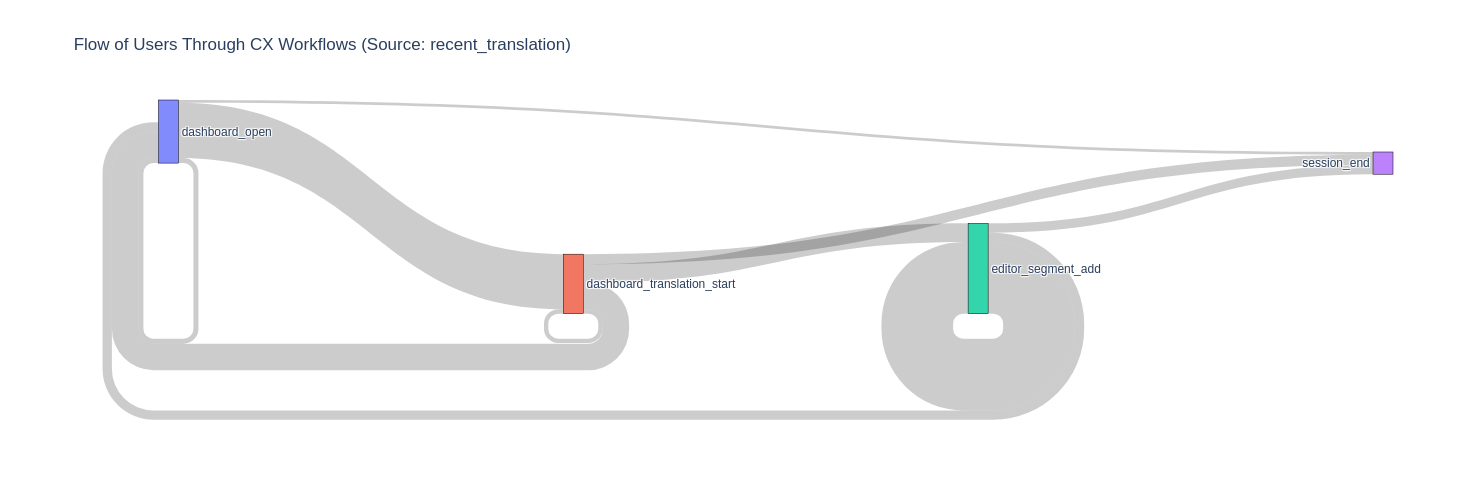

In [291]:
dopen_sources = events.query("""event_type == 'dashboard_open'""").event_source.unique().tolist()
for source in dopen_sources:
    
    sessions_with_source = (
        events
        .query(f"""(event_source == '{source}') & (event_type == 'dashboard_open') & (content_translation_session_position == 0)""")
        .content_translation_session_id
        .unique()
        .tolist()
    )
    
    plot_sankey(events.query("""content_translation_session_id == @sessions_with_source"""), f'Flow of Users Through CX Workflows (Source: {source})')

In [294]:
events.query("""(event_type == 'dashboard_translation_start') & (event_source != @dopen_sources)""").event_source.value_counts()

suggestion_no_seed        962
search_result             861
suggestion_recent_edit    188
suggestion_nearby          31
continue_published         10
Name: event_source, dtype: int64

In [ ]:
events